In [111]:
import numpy as np
import galsim
import batsim
import matplotlib.pyplot as plt
import pyfftw
import multiprocessing

from time import time
from tqdm import tqdm
from scipy.fft import fft, ifft, fft2, ifft2, fftshift, ifftshift

In [112]:
# Set up the gal and Moffat profiles
cosmos = galsim.COSMOSCatalog()
gal = cosmos.makeGalaxy(1, gal_type='parametric')
psf = galsim.Moffat(beta=3.5, fwhm=0.6, flux=1.0)

# Get the Nyquist scale and the good image size for the gal and Moffat profiles
nyq = gal.nyquist_scale
gal_nn = gal.getGoodImageSize(nyq)
psf_nn = psf.getGoodImageSize(nyq)
print(f'Nyquist scale: {nyq}'
      f'\nGalaxy good image size: {gal_nn}'
      f'\nMoffat good image size: {psf_nn}')

# Create the stamps for the gal and Moffat profiles
gal_stamp = batsim.Stamp(nn=gal_nn, scale=nyq)
gal_coords = gal_stamp.coords.T
galx = gal_coords[:,0].tolist()
galy = gal_coords[:,1].tolist()

psf_stamp = batsim.Stamp(nn=psf_nn, scale=nyq)
psf_coords = psf_stamp.coords.T
psfx = psf_coords[:,0].tolist()
psfy = psf_coords[:,1].tolist()

# Get the fluxes for the gal and Moffat profiles
gal_fluxes = batsim._gsinterface.getFluxVec(gal._sbp, galx, galy)
psf_fluxes = batsim._gsinterface.getFluxVec(psf._sbp, psfx, psfy)

# normalise arrays
gal_fluxes /= np.sum(gal_fluxes) / gal.flux
psf_fluxes /= np.sum(psf_fluxes) / psf.flux

print(np.shape(gal_fluxes), np.shape(psf_fluxes))

Nyquist scale: 0.0020012013885005574
Galaxy good image size: 2428
Moffat good image size: 1850
(5895184,) (3422500,)


Scipy 1D time: 7.98790717124939


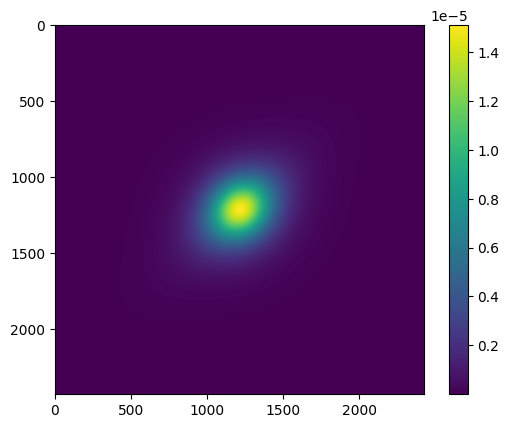

In [113]:
start = time()
# Get the fluxes for the gal and Moffat profiles
gal_fluxes = batsim._gsinterface.getFluxVec(gal._sbp, galx, galy)
psf_fluxes = batsim._gsinterface.getFluxVec(psf._sbp, psfx, psfy)

# normalise arrays
gal_fluxes /= np.sum(gal_fluxes) / gal.flux
psf_fluxes /= np.sum(psf_fluxes) / psf.flux

# Padding calculations
col_pad = (gal_nn - psf_nn) // 2
row_pad = (gal_nn - psf_nn) // 2

# Correct handling for potential even-odd discrepancy
if (gal_nn - psf_nn) % 2 != 0:
    print('shifted')
    col_pad += 1
    row_pad += 1

# Initialize the padded PSF array
psf_padded = np.zeros_like(gal_fluxes)

# Populate the padded PSF array
for i in range(psf_nn):
    for j in range(psf_nn):
        original_index = i * psf_nn + j
        # Adjust for even-odd sizes
        new_index = ((i + col_pad) * gal_nn + (j + row_pad))
        
        psf_padded[new_index] = psf_fluxes[original_index]

# FFT operations and convolution
gal_fluxes_arr = np.array(gal_fluxes)
gal_kprof = fft(gal_fluxes_arr)
psf_kprof = fft(psf_padded)
conv_kprof = gal_kprof * psf_kprof

# Inverse FFT - directly, centering might beneeded afterwards depending on the exact output requirement
conv_im = ifft(conv_kprof)
conv_im = conv_im.real
conv_im = fftshift(conv_im.reshape(gal_nn, gal_nn))
print('Scipy 1D time:', time() - start)

plt.imshow(conv_im)
plt.colorbar()

Galsim time: 0.30661439895629883


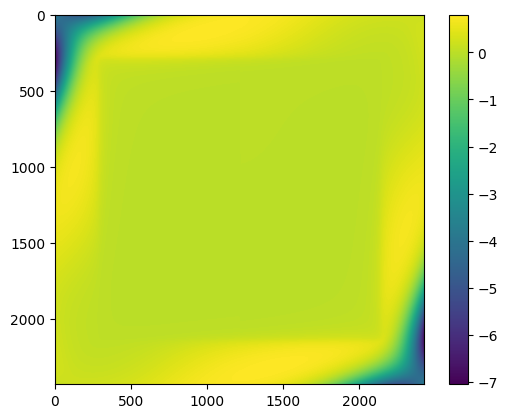

In [114]:
start = time()
gs_im = galsim.Convolve(gal, psf).shift(0.5*nyq, 0.5*nyq).drawImage(nx=gal_nn, ny=gal_nn, scale=nyq, method='auto')
print('Galsim time:', time() - start)
plt.imshow((gs_im.array-conv_im)/gs_im.array)
plt.colorbar()

Scipy 2D time 2.057563304901123


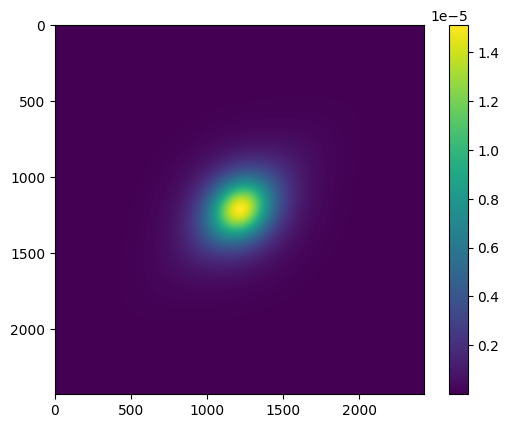

In [115]:
start = time()

# Get the fluxes for the gal and Moffat profiles
gal_fluxes = batsim._gsinterface.getFluxVec(gal._sbp, galx, galy)
psf_fluxes = batsim._gsinterface.getFluxVec(psf._sbp, psfx, psfy)

# normalise arrays
gal_fluxes /= np.sum(gal_fluxes) / gal.flux
psf_fluxes /= np.sum(psf_fluxes) / psf.flux

# Reshape the arrays to 2D
psfProf = psf_fluxes.reshape(psf_nn, psf_nn)
galProf = gal_fluxes.reshape(gal_nn, gal_nn)

pad_width = ((gal_nn - psf_nn) // 2,)
psfProfPad = np.pad(psfProf, pad_width, mode='constant', constant_values=0)

galKprof = fft2(galProf)
psfKprof = fft2(psfProfPad)
convKprof = galKprof * psfKprof

# Inverse FFT - directly, centering might beneeded afterwards depending on the exact output requirement
conv_im = ifftshift(ifft2(convKprof))
conv_im = conv_im.real
conv_im = conv_im.reshape(gal_nn, gal_nn)
print('Scipy 2D time', time() - start)

plt.imshow(conv_im)
plt.colorbar()

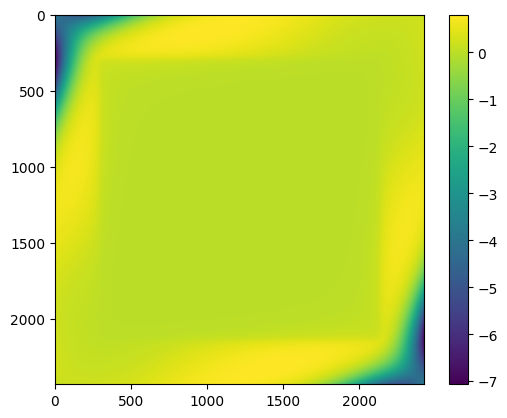

In [116]:
plt.imshow((gs_im.array-conv_im)/gs_im.array)
plt.colorbar()

C++ 2D time 1.9748587608337402


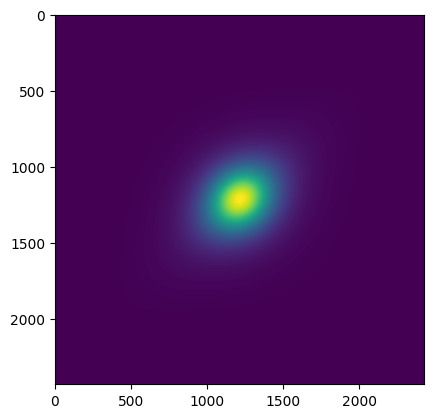

In [117]:
### Test C++ implementation
rescale = 1
start = time()
conv_im = batsim._gsinterface.convolveImage(gal._sbp, psf._sbp, galx, galy, psfx, psfy, rescale)
conv_im /= np.sum(conv_im) / (gal.flux * psf.flux)
conv_im = fftshift(np.reshape(conv_im, (gal_nn, gal_nn)))
print('C++ 2D time', time() - start)
plt.imshow(conv_im)

2.6953378 2.699868382752248


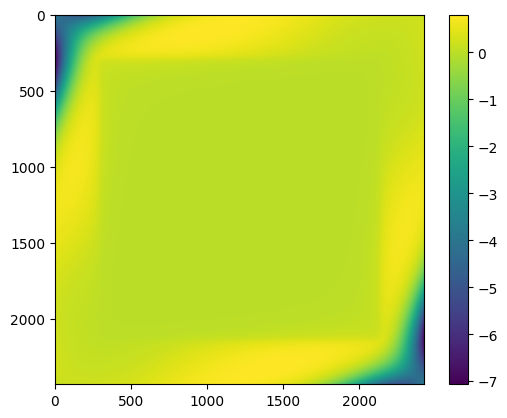

In [118]:
plt.imshow((gs_im.array-conv_im)/gs_im.array)
print(np.sum(gs_im.array), np.sum(conv_im))
plt.colorbar()

### Try getting k-space profile in Python
